<a href="https://colab.research.google.com/github/beastboy-93/wildecho/blob/main/audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{0: 'Bear', 1: 'Cat', 2: 'Cow', 3: 'Dog', 4: 'Donkey', 5: 'Elephant', 6: 'Horse', 7: 'Lion', 8: 'Monkey', 9: 'Sheep'}
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2022 - loss: 2.7116
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to /content/drive/MyDrive/best_sound.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 293ms/step - accuracy: 0.2036 - loss: 2.7038 - val_accuracy: 0.1000 - val_loss: 2.5181 - learning_rate: 1.0000e-04
Epoch 2/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5162 - loss: 1.4953
Epoch 2: val_accuracy did not improve from 0.10000
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5179 - loss: 1.4916 - val_accuracy: 0.1000 - val_loss: 2.9087 - learning_rate: 1.0000e-04
Epoch 3/50
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6144 - loss: 1.1524
Epoch 3: val_accuracy did not improve from 0.1

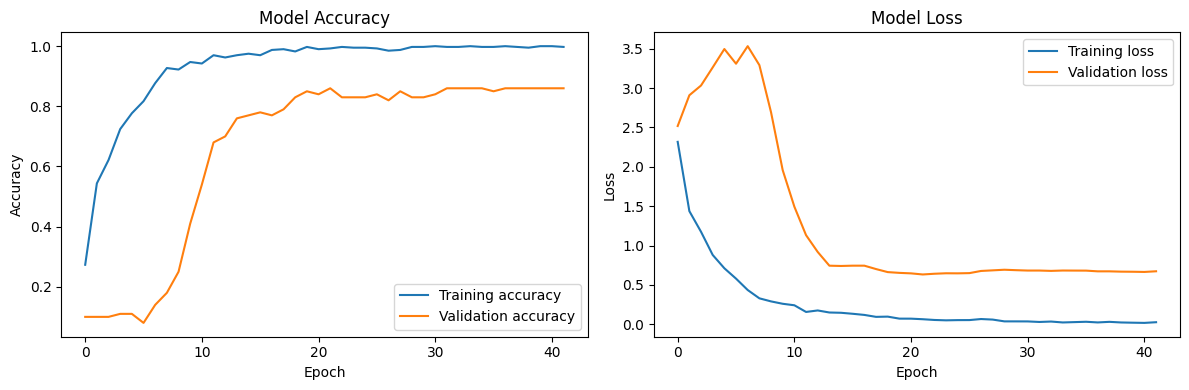

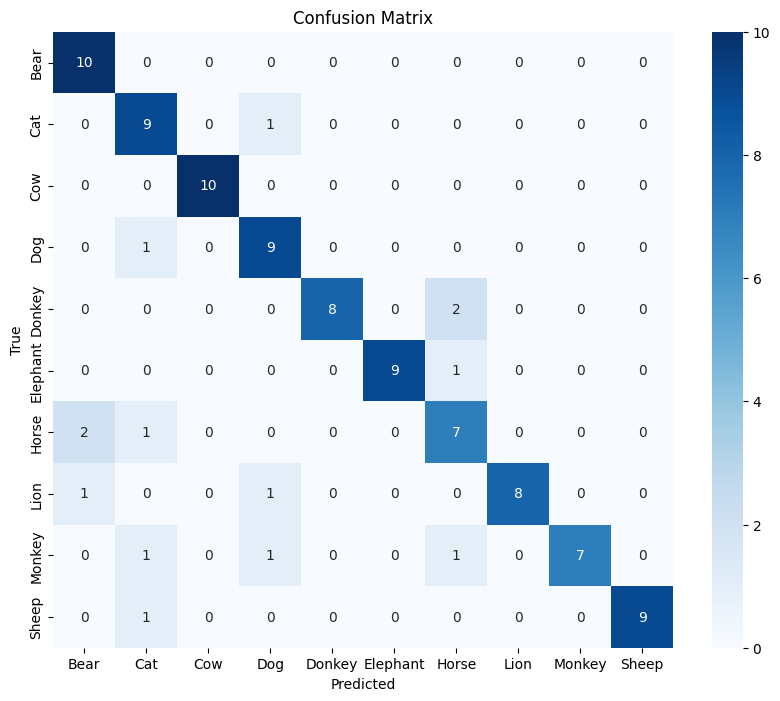

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
Predicted Animal: Lion (Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Animal: Monkey (Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Animal: Sheep (Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Animal: Cow (Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted Animal: Horse (Confidence: 1.00)


In [2]:
# Connect the dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Installing required libraries

# !pip install librosa
# !pip install soundfile
# !pip install tensorflow
# !pip install seaborn

# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path and Parameters
DATASET_PATH = "/content/drive/MyDrive/sounds"
N_MELS, MAX_PAD_LEN, SAMPLE_RATE = 128, 174, 22050

# Function to extract mel spectrogram
def extract_mel_spectrogram(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        y, _ = librosa.effects.trim(y, top_db=20)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=2048, hop_length=256, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec + 1e-9, ref=np.max)
        mel_spec_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db) + 1e-9)
        mel_spec_padded = np.zeros((N_MELS, MAX_PAD_LEN))
        mel_spec_padded[:, :min(MAX_PAD_LEN, mel_spec_norm.shape[1])] = mel_spec_norm[:, :MAX_PAD_LEN]
        return mel_spec_padded
    except:
        return None


# Define labels
labels = {0: 'Bear', 1: 'Cat', 2: 'Cow', 3: 'Dog', 4: 'Donkey', 5: 'Elephant', 6: 'Horse', 7: 'Lion', 8: 'Monkey', 9: 'Sheep'}

# Initialize X and y
X, y = [], []

# Data Processing
for idx, animal in labels.items():
    animal_folder = os.path.join(DATASET_PATH, animal)
    if os.path.isdir(animal_folder):
        for file in filter(lambda f: f.endswith(".wav"), os.listdir(animal_folder)):
            feature = extract_mel_spectrogram(os.path.join(animal_folder, file))
            if feature is not None:
                X.append(feature)
                y.append(idx)

print(labels)

# Convert to numpy arrays
X, y = np.array(X)[..., np.newaxis], to_categorical(y, num_classes=len(labels))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))
class_weight_dict = dict(enumerate(compute_class_weight('balanced', classes=np.unique(np.argmax(y, axis=1)), y=np.argmax(y, axis=1))))

# CNN Model
def create_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'), BatchNormalization(), MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'), BatchNormalization(), MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'), BatchNormalization(), MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'), BatchNormalization(), MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'), BatchNormalization(), Dropout(0.5),
        Dense(256, activation='relu'), Dropout(0.3), Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model((N_MELS, MAX_PAD_LEN, 1), len(labels))

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=8,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight_dict,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
                               EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1),
                               ModelCheckpoint('/content/drive/MyDrive/best_sound.keras', monitor='val_accuracy', save_best_only=True, verbose=1)],
                    verbose=1)


# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[labels[i] for i in range(len(labels))], zero_division=0))

# Plot training history
plt.figure(figsize=(12, 4))
for metric in ['accuracy', 'loss']:
    plt.subplot(1, 2, 1 if metric == 'accuracy' else 2)
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[labels[i] for i in range(len(labels))], yticklabels=[labels[i] for i in range(len(labels))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Predictions
def predict_animal(AUDIO_FILE):
    feature = extract_mel_spectrogram(AUDIO_FILE)
    if feature is not None:
        spectrogram = feature[np.newaxis, ..., np.newaxis]
        predictions = model.predict(spectrogram)
        predicted_label = np.argmax(predictions)
        print(f"Predicted Animal: {labels[predicted_label]} (Confidence: {predictions[0][predicted_label]:.2f})")
    else:
        print(f"Error: Could not process {AUDIO_FILE}")

for AUDIO_FILE in ["/content/drive/MyDrive/test_as/Lion_8.wav", "/content/drive/MyDrive/test_as/Monkey_9.wav",
                   "/content/drive/MyDrive/test_as/Sheep_11.wav", "/content/drive/MyDrive/test_as/Cow_8.wav",
                   "/content/drive/MyDrive/test_as/Horse_10.wav"]:
    predict_animal(AUDIO_FILE)
